In [301]:
# Import necessary libraries
import ccxt
import os
from dotenv import load_dotenv
import json
from pprint import pprint
import pandas as pd
from IPython.display import display, JSON
import matplotlib.pyplot as plt
# Import necessary libraries
import time
import requests
import hmac
import os
from hashlib import sha256
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


True

In [302]:


# Load environment variables from .env file

# Retrieve API keys from environment variables
api_key = os.getenv('BINGX_API_KEY')
secret_key = os.getenv('BINGX_SECRET_KEY')

# Initialize the BingX exchange with API keys
exchange = ccxt.bingx({
    'apiKey': api_key,
    'secret': secret_key, 
})

# Load markets to ensure that the exchange's markets are initialized
exchange.load_markets()


def fetchBalance():
    balance = exchange.fetchBalance()
    return balance


# Function to fetch all trade history
def get_all_trade_history(symbol=None, limit=1000):
    try:
        # If a specific symbol is provided, fetch trades for that symbol, otherwise fetch all trades
        trades = exchange.fetchTrades(symbol=symbol)
        # trades = exchange.fetchBalance()
        
        # Print the trade history
        for trade in trades:
            print(f"Trade ID: {trade['id']}, Symbol: {trade['symbol']}, "
                  f"Side: {trade['side']}, Price: {trade['price']}, "
                  f"Amount: {trade['amount']}, Timestamp: {trade['datetime']}")
        
        # Return the trade history
        return trades
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Example usage
# Fetch all trade history (you can specify a symbol like 'BTC/USDT' if needed)
SYMBOL = "BTC/USDT"
trade_history = get_all_trade_history(symbol=SYMBOL)

# Print the number of trades fetched
print(f"Total trades fetched: {len(trade_history)}")
print(trade_history)

Trade ID: 128567921, Symbol: BTC/USDT, Side: sell, Price: 90661.1, Amount: 0.0006441924927008386, Timestamp: 2024-11-17T14:14:07.643Z
Trade ID: 128567922, Symbol: BTC/USDT, Side: buy, Price: 90661.09, Amount: 0.052541487202503304, Timestamp: 2024-11-17T14:14:07.658Z
Trade ID: 128567923, Symbol: BTC/USDT, Side: buy, Price: 90661.92, Amount: 0.004429911698318323, Timestamp: 2024-11-17T14:14:08.644Z
Trade ID: 128567924, Symbol: BTC/USDT, Side: sell, Price: 90661.95, Amount: 0.0016041558779620335, Timestamp: 2024-11-17T14:14:08.658Z
Trade ID: 128567925, Symbol: BTC/USDT, Side: buy, Price: 90661.93, Amount: 0.005748080809662887, Timestamp: 2024-11-17T14:14:09.216Z
Trade ID: 128567926, Symbol: BTC/USDT, Side: buy, Price: 90661.9, Amount: 0.0023415569274414056, Timestamp: 2024-11-17T14:14:09.216Z
Trade ID: 128567927, Symbol: BTC/USDT, Side: buy, Price: 90661.92, Amount: 0.004377442039612663, Timestamp: 2024-11-17T14:14:09.817Z
Trade ID: 128567928, Symbol: BTC/USDT, Side: buy, Price: 90661.93,

In [303]:


# Retrieve API keys from environment variables
APIURL = "https://open-api.bingx.com"
APIKEY = os.getenv('BINGX_API_KEY')
SECRETKEY = os.getenv('BINGX_SECRET_KEY')

def get_trade_history(symbol="BTC-USDT", order_id=None, start_time=0, end_time=0, limit=100):
    """Function to fetch trade history from BingX"""
    payload = {}
    path = '/openApi/contract/v1/allOrders'
    method = "GET"
    params_map = {
        "symbol": symbol,
        # "orderId": order_id,
        # "startTime": start_time,
        # "endTime": end_time,
        # "limit": limit
    }
    params_str = parse_param(params_map)
    return send_request(method, path, params_str, payload)

def get_sign(api_secret, payload):
    """Generate HMAC SHA256 signature"""
    signature = hmac.new(api_secret.encode("utf-8"), payload.encode("utf-8"), digestmod=sha256).hexdigest()
    return signature

def send_request(method, path, url_params, payload):
    """Send the request to BingX API"""
    url = f"{APIURL}{path}?{url_params}&signature={get_sign(SECRETKEY, url_params)}"
    headers = {'X-BX-APIKEY': APIKEY}
    
    response = requests.request(method, url, headers=headers, data=payload)
    
    # Check for errors in the response
    if response.status_code == 200:
        return response.json()  # Return the response as a JSON object
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return {}

def parse_param(params_map):
    """Parse parameters into a URL-encoded string and add a timestamp"""
    sorted_keys = sorted(params_map)
    params_str = "&".join([f"{key}={params_map[key]}" for key in sorted_keys])
    return f"{params_str}&timestamp={int(time.time() * 1000)}"

# Example usage in a Jupyter notebook
trade_history = get_trade_history()

# Display the trade history
import json
print(json.dumps(trade_history, indent=4))

{
    "code": 0,
    "timestamp": 1731852933460,
    "data": [
        {
            "margin": 87.74,
            "leverage": 8.0,
            "closePrice": 90990.0,
            "positionId": 1375653998986502150,
            "isolated": true,
            "avgPrice": 91130.74,
            "cumQuote": 701.92,
            "executedQty": 0.00770234,
            "orderId": 1375653998986502150,
            "positionSide": "LONG",
            "status": "CLOSED",
            "symbol": "BTC-USDT",
            "time": 1731835967000,
            "updateTime": 1731840920000
        },
        {
            "margin": 87.55,
            "leverage": 8.0,
            "closePrice": 91387.76,
            "positionId": 1375647839679725573,
            "isolated": true,
            "avgPrice": 91454.34,
            "cumQuote": 700.4,
            "executedQty": 0.00765846,
            "orderId": 1375647839679725573,
            "positionSide": "SHORT",
            "status": "CLOSED",
            "symbol": 

In [304]:
def get_pnl(data):
    df = pd.DataFrame(data)

    # Group by positionId to aggregate trades that belong to the same position
    grouped = df.groupby('positionId').agg({
        'avgPrice': 'mean',                  # Average entry price
        'closePrice': 'mean',                # Average closing price
        'cumQuote': 'sum',                   # Total quote amount
        'executedQty': 'sum',                # Total executed quantity
        'margin': 'sum',                     # Total margin used
        'leverage': 'mean',                  # Average leverage
        'positionSide': 'first',             # Position side (e.g., LONG/SHORT)
        'symbol': 'first',                   # Symbol (e.g., BTC-USDT)
        'status': 'first',                   # Status of the trade (e.g., CLOSED)
        'time': 'min',                       # Earliest time of the trade
        'updateTime': 'max'                  # Latest update time of the trade
    }).reset_index()

    # Adjust profit/loss calculation based on position side (LONG/SHORT)
    def calculate_profit_loss(row):
        if row['positionSide'] == 'LONG':
            return (row['closePrice'] - row['avgPrice']) * row['executedQty']
        elif row['positionSide'] == 'SHORT':
            return (row['avgPrice'] - row['closePrice']) * row['executedQty']
        else:
            return 0

    # Calculate profit/loss
    grouped['profit_loss'] = grouped.apply(calculate_profit_loss, axis=1)

    # Calculate commission as 0.05% of (margin * leverage)
    grouped['commission'] = 0.00045 * (grouped['margin'] * grouped['leverage'])

    # Calculate net profit/loss by subtracting the commission from the profit/loss
    grouped['net_profit_loss'] = grouped['profit_loss'] - grouped['commission']

    # Calculate percentage gain or loss based on net profit/loss
    grouped['percentage_gain_loss'] = (grouped['net_profit_loss'] / grouped['margin']) * 100

    # Sort the DataFrame by 'time' in descending order (most recent trades first)
    grouped = grouped.sort_values(by='time', ascending=False)

    # Display the aggregated and sorted DataFrame in the Jupyter notebook
    grouped.style.format({
        'avgPrice': '{:.2f}',
        'closePrice': '{:.2f}',
        'cumQuote': '{:.2f}',
        'executedQty': '{:.6f}',
        'margin': '{:.2f}',
        'profit_loss': '{:.2f}',
        'commission': '{:.2f}',
        'net_profit_loss': '{:.2f}',
        'percentage_gain_loss': '{:.2f}%'
    })
    return grouped


pnl = get_pnl(trade_history['data'])
pnl

,positionId,avgPrice,closePrice,cumQuote,executedQty,margin,leverage,positionSide,symbol,status,time,updateTime,profit_loss,commission,net_profit_loss,percentage_gain_loss
160,1375653998986502150,91130.74,90990.00,701.92,0.007702,87.74,8.0,LONG,BTC-USDT,CLOSED,1731835967000,1731840920000,-1.084027,0.315864,-1.399891,-1.595500
159,1375647839679725573,91454.34,91387.76,700.40,0.007658,87.55,8.0,SHORT,BTC-USDT,CLOSED,1731834498000,1731835073000,0.509900,0.315180,0.194720,0.222410
158,1375646775312883712,91245.45,91350.00,709.44,0.007775,88.68,8.0,SHORT,BTC-USDT,CLOSED,1731834244000,1731834334000,-0.812884,0.319248,-1.132132,-1.276648
157,1375641738964606979,90862.77,91148.17,730.40,0.008038,91.30,8.0,SHORT,BTC-USDT,CLOSED,1731833044000,1731834130000,-2.294185,0.328680,-2.622865,-2.872799
156,1375612109442035714,90738.97,90654.78,454.75,0.005012,90.95,5.0,SHORT,BTC-USDT,CLOSED,1731825979000,1731831777000,0.421928,0.204637,0.217291,0.238912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1368833997366804482,71610.54,71700.00,585.15,0.008171,117.03,5.0,SHORT,BTC-USDT,CLOSED,1730209951000,1730209983000,-0.731003,0.263317,-0.994320,-0.849628
3,1368833476540051460,71496.38,71600.00,584.75,0.008179,116.95,5.0,SHORT,BTC-USDT,CLOSED,1730209827000,1730209864000,-0.847480,0.263137,-1.110618,-0.949652
2,1368458665042284548,68994.60,68897.06,402.08,0.005828,57.44,7.0,SHORT,BTC-USDT,CLOSED,1730120465000,1730122675000,0.568434,0.180936,0.387498,0.674613
1,1367434148345974791,67764.34,67306.92,550.00,0.008116,110.00,5.0,SHORT,BTC-USDT,CLOSED,1729876201000,1729878948000,3.712585,0.247500,3.465085,3.150078


In [305]:
def calculate_accuracy(data, profit_metric='net_profit_loss', last_m_trades=None, last_n_days=None):
    # Ensure 'data' is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame.")

    # Use only one of the filters: last_m_trades or last_n_days
    if last_n_days is not None:
        # Filter data to include only trades from the last n days
        data['time'] = pd.to_datetime(data['time'], unit='ms')

        cutoff_date = pd.Timestamp.now() - pd.Timedelta(days=last_n_days)
        data = data[data['time'] >= cutoff_date]
    elif last_m_trades is not None:
        # Sort by time in descending order and take the last m trades
        data = data.sort_values(by='time', ascending=False).head(last_m_trades)
    
    # Calculate the number of winning trades
    winning_trades = data[data[profit_metric] > 0].shape[0]
    
    # Calculate accuracy
    total_trades = data.shape[0]
    accuracy = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    
    return accuracy, total_trades

# Example usage
profit_metric = 'profit_loss'  # Choose between 'profit_loss' and 'net_profit_loss'
last_m_trades = None  # Number of recent trades to consider (set to None if not using)
last_n_days = 1  # Number of days to consider (set to None if not using)

accuracy, total_trades = calculate_accuracy(pnl, profit_metric, last_m_trades, last_n_days)

# Display the results
print(f"Accuracy over the last {total_trades} trades: {accuracy:.2f}%")

Accuracy over the last 5 trades: 40.00%


BackTest


In [306]:
# Import necessary libraries
import math
import ccxt
import pandas as pd
import mplfinance as mpf
import time

# Initialize the BingX exchange
exchange = ccxt.bingx()
# exchange = ccxt.bitstamp()

# Load markets to ensure that the exchange's markets are initialized
exchange.load_markets()

# Function to fetch and prepare data
def get_ohlcv_data(symbol,since, timeframe, limit):
    # Ensure the exchange has the symbol and timeframe
    if symbol not in exchange.symbols:
        raise ValueError(f"Symbol {symbol} not available on BingX.")
    if timeframe not in exchange.timeframes:
        raise ValueError(f"Timeframe {timeframe} not available on BingX.")
    
    # Fetch OHLCV data
    try:
        data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    except Exception as e:
        print(f"An error occurred while fetching {symbol} data: {e}")
        return pd.DataFrame()
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    
    # Convert UTC to IST
    df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Kolkata')
    df.set_index('timestamp', inplace=True)
    df = df.astype(float)
    return df

# Define symbols (commodities and currency pairs)
# symbols = ['BTC/USDT', 'EUR/USDT', 'JPY/USDT', 'GBP/USDT', 'XAU/USDT', 'USOIL/USDT']

# Define time frames (you can modify this list)
# timeframes = ['1m', '5m', '15m', '30m', '1h', '4h']

symbols = ['BTC/USDT']
timeframes = ['1m', '5m', '15m', '1h']

# Number of data points to fetch
limit = 150

# Function to plot multiple symbols and timeframes
def plot_symbols_timeframes(symbols, timeframes):
    total_plots = len(symbols) * len(timeframes)
    cols = 2  # Number of columns in the subplot grid
    rows = math.ceil(total_plots / cols)

    # Adjust figure size dynamically
    figure_width = 20  # Fixed width in inches
    figure_height_per_row = 5  # Height per row in inches
    figure_height = rows * figure_height_per_row
    figure_size = (figure_width, figure_height)

    # Create a custom style with adjusted font sizes
    custom_style = mpf.make_mpf_style(
        base_mpf_style='charles',
        rc={
            'font.size': 10,            # General font size
            'axes.labelsize': 12,       # Axis label font size
            'xtick.labelsize': 8,       # X-axis tick label font size
            'ytick.labelsize': 8,       # Y-axis tick label font size
            'figure.titlesize': 14      # Figure title font size
        }
    )

    # Create the figure
    fig = mpf.figure(figsize=figure_size, style=custom_style)
    axs = []

    # Create subplots dynamically
    for i in range(1, total_plots + 1):
        ax = fig.add_subplot(rows, cols, i)
        axs.append(ax)

    idx = 0  # Index for accessing axs
    for symbol in symbols:
        for timeframe in timeframes:
            print(f"Fetching data for {symbol} at interval {timeframe}...")
            df = get_ohlcv_data(symbol, timeframe, limit)
            
            if df.empty:
                print(f"No data fetched for {symbol} at interval {timeframe}.\n")
                idx += 1
                continue
            
            print(f"Plotting chart for {symbol} at interval {timeframe}...")
            
            # Plot on the specified axes
            mpf.plot(
                df,
                type='candle',
                ax=axs[idx],
                style=custom_style,
                volume=False,  # Set to True if you want to include volume and pass volume axes
                axtitle=f'{symbol} {timeframe}',
                ylabel='Price',
                show_nontrading=False
            )
            print(f"Chart plotted for {symbol} at interval {timeframe}.\n")
            idx += 1
            # Pause to avoid rate limits
            time.sleep(exchange.rateLimit / 1000)

    # Hide any unused subplots
    total_subplots = rows * cols
    if idx < total_subplots:
        for i in range(idx, total_subplots):
            fig.delaxes(axs[i])

    # Adjust layout to prevent overlap
    fig.tight_layout()

    # Display and save the figure
    # mpf.show()  # Display the figure
    fig.savefig('Combined_Symbols_Timeframes.png')

    print("Combined chart saved as Combined_Symbols_Timeframes.png")

# Call the function to plot symbols and timeframes
# plot_symbols_timeframes(symbols, timeframes)

In [307]:
df

,open,high,low,close,volume
timestamp,,,,,
2024-11-17 03:00:00+05:30,91033.08,91063.10,91017.95,91018.01,0.139198
2024-11-17 03:01:00+05:30,91017.90,91026.56,91017.75,91024.29,0.287660
2024-11-17 03:02:00+05:30,91024.26,91024.31,90971.72,90993.35,0.147180
2024-11-17 03:03:00+05:30,90993.36,91004.64,90954.49,90954.98,0.134286
2024-11-17 03:04:00+05:30,90955.00,91017.95,90955.00,90992.51,0.158506
...,...,...,...,...,...
2024-11-17 19:35:00+05:30,90675.54,90715.97,90660.61,90715.96,0.108800
2024-11-17 19:36:00+05:30,90733.54,90765.08,90691.15,90702.92,0.160256
2024-11-17 19:37:00+05:30,90722.45,90736.68,90707.08,90707.32,0.295978


In [308]:
import pandas as pd
def plot_pnl(trades_df):
    df = pd.DataFrame(trades_df)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Calculate PnL based on whether the trade hit SL or TP
    df['PnL'] = df.apply(lambda row: -row['SL Points'] if row['Result'] == 'SL' else row['TP Points'], axis=1)

    # Calculate cumulative PnL
    df['Cumulative PnL'] = df['PnL'].cumsum()

    # Plot cumulative PnL over time
    plt.figure(figsize=(10, 5))
    plt.plot(df['Timestamp'], df['Cumulative PnL'], marker='o', linestyle='-')
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative PnL')
    plt.title('Cumulative PnL Over Time')
    plt.xticks(rotation=45)
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


import pandas as pd

def backtest_engulfing_strategy(df, risk_reward=1, max_sl_points=None, min_sl_points=None):
    """
    Backtests a bullish and bearish engulfing strategy on the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing OHLCV data.
    risk_reward (float): The risk-to-reward ratio for take profit calculation.
    max_sl_points (float or None): Maximum allowed SL points to filter trades. If None, all trades are considered.
    min_sl_points (float or None): Minimum required SL points to filter trades. If None, all trades are considered.

    Returns:
    pd.DataFrame: A DataFrame containing trade details.
    float: The total net profit from all trades.
    float: The accuracy of the trades in percentage.
    """
    df['timestamp'] = pd.to_datetime(df.index)
    df.set_index('timestamp', inplace=True)

    # Initialize variables
    trades = []
    total_profit = 0
    successful_trades = 0

    # Iterate through the DataFrame to look for engulfing patterns
    for i in range(1, len(df) - 1):
        prev_candle = df.iloc[i - 1]
        curr_candle = df.iloc[i]

        # Calculate the size of the previous candle and the current candle
        prev_candle_size = abs(prev_candle['close'] - prev_candle['open'])
        curr_candle_size = abs(curr_candle['close'] - curr_candle['open'])

        # Check for a bullish engulfing pattern
        if (curr_candle['close'] > curr_candle['open'] and  # Current candle is bullish
            curr_candle['open'] <= prev_candle['close'] and  # Current candle opens lower than the previous close
            curr_candle['open'] <= prev_candle['open'] and
            curr_candle['close'] >= prev_candle['open'] and  # Current candle closes higher than the previous open
            curr_candle['close'] >= prev_candle['close'] and
            curr_candle_size >= 4 * prev_candle_size):  # Current candle is at least twice the size of the previous candle
            
            # Set entry, stop loss, and target prices
            entry_price = curr_candle['close']
            stop_loss = prev_candle['low']
            sl_points = entry_price - stop_loss
            tp_points = sl_points * risk_reward
            target_price = entry_price + tp_points

            # Filter out trades if SL points do not meet criteria
            if (max_sl_points is not None and sl_points > max_sl_points) or \
               (min_sl_points is not None and sl_points < min_sl_points):
                continue

            # Check if the trade hits SL or TP
            hit_tp = False
            for j in range(i + 1, len(df)):
                future_candle = df.iloc[j]
                if future_candle['low'] <= stop_loss:  # Stop loss hit
                    total_profit -= sl_points
                    break
                elif future_candle['high'] >= target_price:  # Take profit hit
                    total_profit += tp_points
                    successful_trades += 1
                    hit_tp = True
                    break

            # Append trade details
            trades.append({
                'Timestamp': curr_candle.name,
                'Type': 'Long',
                'Entry Price': entry_price,
                'Stop Loss': stop_loss,
                'SL Points': sl_points,
                'Target Price': target_price,
                'TP Points': tp_points,
                'Result': 'TP' if hit_tp else 'SL'
            })
        
        # Check for a bearish engulfing pattern
        elif (curr_candle['close'] < curr_candle['open'] and  # Current candle is bearish
              curr_candle['open'] >= prev_candle['close'] and  # Current candle opens higher than the previous close
              curr_candle['open'] >= prev_candle['open'] and
              curr_candle['close'] <= prev_candle['open'] and  # Current candle closes lower than the previous open
              curr_candle['close'] <= prev_candle['close'] and
              curr_candle_size >= 4 * prev_candle_size):  # Current candle is at least twice the size of the previous candle
            
            # Set entry, stop loss, and target prices
            entry_price = curr_candle['close']
            stop_loss = prev_candle['high']
            sl_points = stop_loss - entry_price
            tp_points = sl_points * risk_reward
            target_price = entry_price - tp_points

            # Filter out trades if SL points do not meet criteria
            if (max_sl_points is not None and sl_points > max_sl_points) or \
               (min_sl_points is not None and sl_points < min_sl_points):
                continue

            # Check if the trade hits SL or TP
            hit_tp = False
            for j in range(i + 1, len(df)):
                future_candle = df.iloc[j]
                if future_candle['high'] >= stop_loss:  # Stop loss hit
                    total_profit -= sl_points
                    break
                elif future_candle['low'] <= target_price:  # Take profit hit
                    total_profit += tp_points
                    successful_trades += 1
                    hit_tp = True
                    break

            # Append trade details
            trades.append({
                'Timestamp': curr_candle.name,
                'Type': 'Short',
                'Entry Price': entry_price,
                'Stop Loss': stop_loss,
                'SL Points': sl_points,
                'Target Price': target_price,
                'TP Points': tp_points,
                'Result': 'TP' if hit_tp else 'SL'
            })

    # Calculate total trades and accuracy
    total_trades = len(trades)
    accuracy = (successful_trades / total_trades) * 100 if total_trades > 0 else 0

    # Create a DataFrame from the trades
    trades_df = pd.DataFrame(trades)

    return trades_df, total_profit, accuracy


import pandas as pd

def backtest_engulfing_strategy_with_ema(df, risk_reward=1, max_sl_points=None, min_sl_points=None, ema_short=9, ema_long=15):
    """
    Backtests a bullish and bearish engulfing strategy on the given DataFrame with EMA crossing condition.

    Parameters:
    df (pd.DataFrame): The DataFrame containing OHLCV data.
    risk_reward (float): The risk-to-reward ratio for take profit calculation.
    max_sl_points (float or None): Maximum allowed SL points to filter trades. If None, all trades are considered.
    min_sl_points (float or None): Minimum required SL points to filter trades. If None, all trades are considered.
    ema_short (int): The period for the short EMA (default is 9).
    ema_long (int): The period for the long EMA (default is 15).

    Returns:
    pd.DataFrame: A DataFrame containing trade details.
    float: The total net profit from all trades.
    float: The accuracy of the trades in percentage.
    """
    # Calculate EMAs
    df['EMA_Short'] = df['close'].ewm(span=ema_short, adjust=False).mean()
    df['EMA_Long'] = df['close'].ewm(span=ema_long, adjust=False).mean()
    
    df['timestamp'] = pd.to_datetime(df.index)
    df.set_index('timestamp', inplace=True)

    # Initialize variables
    trades = []
    total_profit = 0
    successful_trades = 0

    # Iterate through the DataFrame to look for engulfing patterns
    for i in range(1, len(df) - 1):
        prev_candle = df.iloc[i - 1]
        curr_candle = df.iloc[i]

        # Check if the engulfing candle crosses both EMAs
        ema_short_value = curr_candle['EMA_Short']
        ema_long_value = curr_candle['EMA_Long']

        # Bullish engulfing condition with EMA crossing
        if (curr_candle['close'] > curr_candle['open'] and  # Current candle is bullish
            prev_candle['close'] < prev_candle['open'] and  # Previous candle is bearish
            curr_candle['open'] <= prev_candle['close'] and
            curr_candle['close'] >= prev_candle['open'] and
            curr_candle['close'] > ema_short_value and  # Crossing above both EMAs
            curr_candle['close'] > ema_long_value and
            curr_candle['open'] < ema_short_value and
            curr_candle['open'] < ema_long_value):
            
            # Set entry, stop loss, and target prices
            entry_price = curr_candle['close']
            stop_loss = prev_candle['low']
            sl_points = entry_price - stop_loss
            tp_points = sl_points * risk_reward
            target_price = entry_price + tp_points

            # Filter out trades if SL points do not meet criteria
            if (max_sl_points is not None and sl_points > max_sl_points) or \
               (min_sl_points is not None and sl_points < min_sl_points):
                continue

            # Check if the trade hits SL or TP
            hit_tp = False
            for j in range(i + 1, len(df)):
                future_candle = df.iloc[j]
                if future_candle['low'] <= stop_loss:  # Stop loss hit
                    total_profit -= sl_points
                    break
                elif future_candle['high'] >= target_price:  # Take profit hit
                    total_profit += tp_points
                    successful_trades += 1
                    hit_tp = True
                    break

            # Append trade details
            trades.append({
                'Timestamp': curr_candle.name,
                'Type': 'Long',
                'Entry Price': entry_price,
                'Stop Loss': stop_loss,
                'SL Points': sl_points,
                'Target Price': target_price,
                'TP Points': tp_points,
                'Result': 'TP' if hit_tp else 'SL'
            })
        
        # Bearish engulfing condition with EMA crossing
        elif (curr_candle['close'] < curr_candle['open'] and  # Current candle is bearish
              prev_candle['close'] > prev_candle['open'] and  # Previous candle is bullish
              curr_candle['open'] >= prev_candle['close'] and
              curr_candle['close'] <= prev_candle['open'] and
              curr_candle['close'] < ema_short_value and  # Crossing below both EMAs
              curr_candle['close'] < ema_long_value and
              curr_candle['open'] > ema_short_value and
              curr_candle['open'] > ema_long_value):
            
            # Set entry, stop loss, and target prices
            entry_price = curr_candle['close']
            stop_loss = prev_candle['high']
            sl_points = stop_loss - entry_price
            tp_points = sl_points * risk_reward
            target_price = entry_price - tp_points

            # Filter out trades if SL points do not meet criteria
            if (max_sl_points is not None and sl_points > max_sl_points) or \
               (min_sl_points is not None and sl_points < min_sl_points):
                continue

            # Check if the trade hits SL or TP
            hit_tp = False
            for j in range(i + 1, len(df)):
                future_candle = df.iloc[j]
                if future_candle['high'] >= stop_loss:  # Stop loss hit
                    total_profit -= sl_points
                    break
                elif future_candle['low'] <= target_price:  # Take profit hit
                    total_profit += tp_points
                    successful_trades += 1
                    hit_tp = True
                    break

            # Append trade details
            trades.append({
                'Timestamp': curr_candle.name,
                'Type': 'Short',
                'Entry Price': entry_price,
                'Stop Loss': stop_loss,
                'SL Points': sl_points,
                'Target Price': target_price,
                'TP Points': tp_points,
                'Result': 'TP' if hit_tp else 'SL'
            })

    # Calculate total trades and accuracy
    total_trades = len(trades)
    accuracy = (successful_trades / total_trades) * 100 if total_trades > 0 else 0

    # Create a DataFrame from the trades
    trades_df = pd.DataFrame(trades)

    return trades_df, total_profit, accuracy

In [330]:
symbol = 'BTC/USDT'
timeframe = '5m'

# Number of data points to fetch
limit = 50000
# df = get_ohlcv_data(symbol,since, timeframe, limit)

In [331]:
import ccxt
import pandas as pd
import time
import pytz
from datetime import datetime

# Initialize the exchange
exchange = ccxt.bingx()  # Replace with your exchange name

# Define the UTC+5:30 time zone
utc_plus_530 = pytz.timezone('Asia/Kolkata')

# Define start and end times in UTC+5:30
start_time_local = utc_plus_530.localize(datetime(2024, 10, 1, 0, 0))  # Start date in UTC+5:30
end_time_local = utc_plus_530.localize(datetime(2024, 11, 17, 0, 0))  # End date in UTC+5:30

# Convert start and end times to UTC for ccxt
start_time = int(start_time_local.astimezone(pytz.UTC).timestamp() * 1000)
end_time = int(end_time_local.astimezone(pytz.UTC).timestamp() * 1000)

# Container to store all data
all_data = []


# Fetch data in chunks
current_time = start_time
while current_time < end_time:
    try:
        # Fetch OHLCV data
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=current_time, limit=limit)
        if not ohlcv:
            break

        # Append the data to all_data
        all_data.extend(ohlcv)

        # Update the current time to the timestamp of the last data point
        current_time = ohlcv[-1][0] + 1  # Move forward by one millisecond to avoid overlap

        # Respect the exchange's rate limits
        time.sleep(exchange.rateLimit / 1000)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        break

# Convert the data to a DataFrame
df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# Convert the timestamp to UTC+5:30
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Kolkata')

# Display the DataFrame
print(df)

                      timestamp      open      high       low     close  \
0     2024-10-01 00:05:00+05:30  63225.21  63374.79  63199.54  63351.61   
1     2024-10-01 00:10:00+05:30  63359.94  63432.45  63297.72  63348.80   
2     2024-10-01 00:15:00+05:30  63348.78  63464.50  63348.74  63362.75   
3     2024-10-01 00:20:00+05:30  63365.21  63430.53  63320.75  63424.57   
4     2024-10-01 00:25:00+05:30  63424.24  63426.61  63341.63  63342.21   
...                         ...       ...       ...       ...       ...   
13770 2024-11-17 19:35:00+05:30  90675.54  90765.08  90615.66  90646.79   
13771 2024-11-17 19:40:00+05:30  90646.45  90683.39  90571.05  90663.26   
13772 2024-11-17 19:45:00+05:30  90678.61  90706.73  90464.30  90532.49   
13773 2024-11-17 19:50:00+05:30  90532.84  90575.65  90338.91  90354.91   
13774 2024-11-17 19:55:00+05:30  90359.97  90367.18  90188.88  90189.21   

         volume  
0      3.564782  
1      3.766833  
2      4.044240  
3      3.055861  
4      2.

                        Timestamp   Type  Entry Price  Stop Loss  SL Points  \
0   1970-01-01 00:00:00.000000007  Short     63353.20   63510.16     156.96   
1   1970-01-01 00:00:00.000000051  Short     63558.06   63620.89      62.83   
2   1970-01-01 00:00:00.000000086  Short     63475.98   63614.90     138.92   
3   1970-01-01 00:00:00.000000089  Short     63353.29   63470.53     117.24   
4   1970-01-01 00:00:00.000000095   Long     63398.67   63331.85      66.82   
..                            ...    ...          ...        ...        ...   
492 1970-01-01 00:00:00.000013676   Long     90581.34   90417.06     164.28   
493 1970-01-01 00:00:00.000013697  Short     90486.62   90557.20      70.58   
494 1970-01-01 00:00:00.000013722  Short     91189.41   91328.51     139.10   
495 1970-01-01 00:00:00.000013727  Short     91107.93   91171.55      63.62   
496 1970-01-01 00:00:00.000013772  Short     90532.49   90683.39     150.90   

     Target Price  TP Points Result  
0        6288

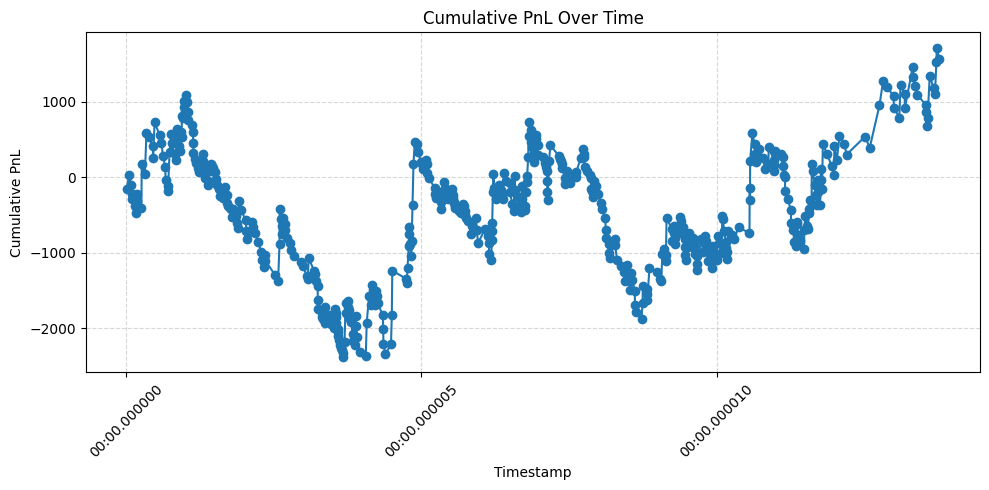

In [332]:
risk_reward = 3
max_sl_points = 200
min_sl_points = 20
trades_df, total_profit, accuracy = backtest_engulfing_strategy(df, risk_reward=risk_reward, min_sl_points=min_sl_points, max_sl_points=max_sl_points)
# trades_df, total_profit, accuracy = backtest_engulfing_strategy_with_ema(df, risk_reward=1, max_sl_points=None, min_sl_points=None, ema_short=20, ema_long=20)
pprint(trades_df)
print(f"Total Net Profit: {total_profit}")
print(f"Trade Accuracy: {accuracy:.2f}%")
plot_pnl(trades_df=trades_df)

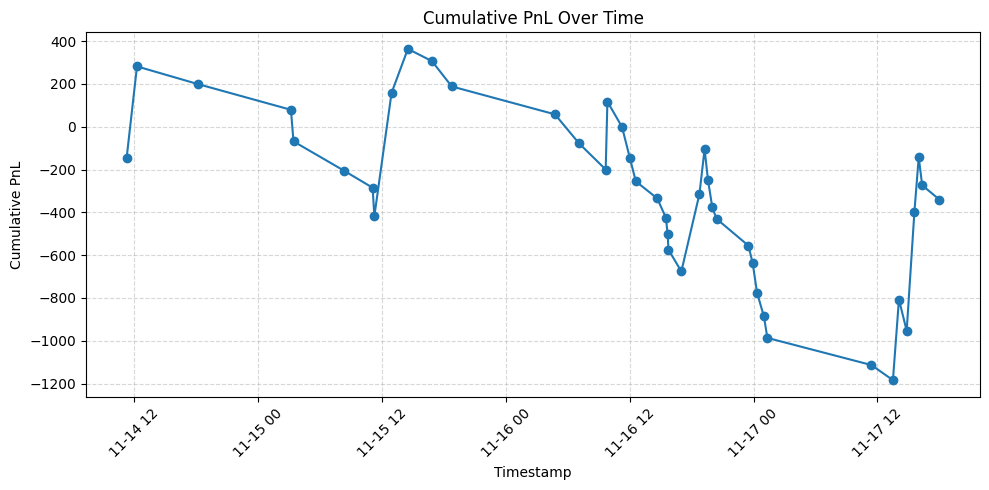